# DSA210 Project
## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datascience import *
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Reading dataset table obtained from kindle sessions:

In [3]:
KindleTable = Table.read_table("Kindle.Devices.ReadingSession_Revised_Jupyter.csv")
KindleTable

start_timestamp,end_timestamp,ASIN,purchased_marketplace,preferred_marketplace,device_family,device_serial_number,device_software_version,content_type,total_reading_millis,pageflips
2024-07-06T19:08:12Z,2024-07-06T19:08:57Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,44500,7
2024-07-06T19:22:08Z,2024-07-06T19:24:47Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,158900,19
2024-07-06T19:46:23Z,2024-07-06T19:46:42Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,19000,7
2024-07-06T19:52:27Z,2024-07-06T19:52:29Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,1900,1
2024-07-06T20:16:05Z,2024-07-06T20:16:07Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,1600,1
2024-07-06T20:16:24Z,2024-07-06T20:20:27Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,243700,22
2024-07-06T20:31:55Z,2024-07-06T20:32:55Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,59200,4
2024-07-06T20:34:32Z,2024-07-06T20:34:38Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,6300,1
2024-07-06T20:36:00Z,2024-07-06T20:36:06Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,5800,1
2024-07-06T20:40:08Z,2024-07-06T20:41:50Z,BE759EFB04D54FCF96A50EAD2154A784,nan,www.amazon.com,Kindle E-reader,G092AQ03247401W4,4246240033,Personal Document,101300,18


My data choice lead me to using broken bar charts to illustrate which time of the day that I read.
 
Mainly preproccessing data dates and creating a chart using start and end timestamps.

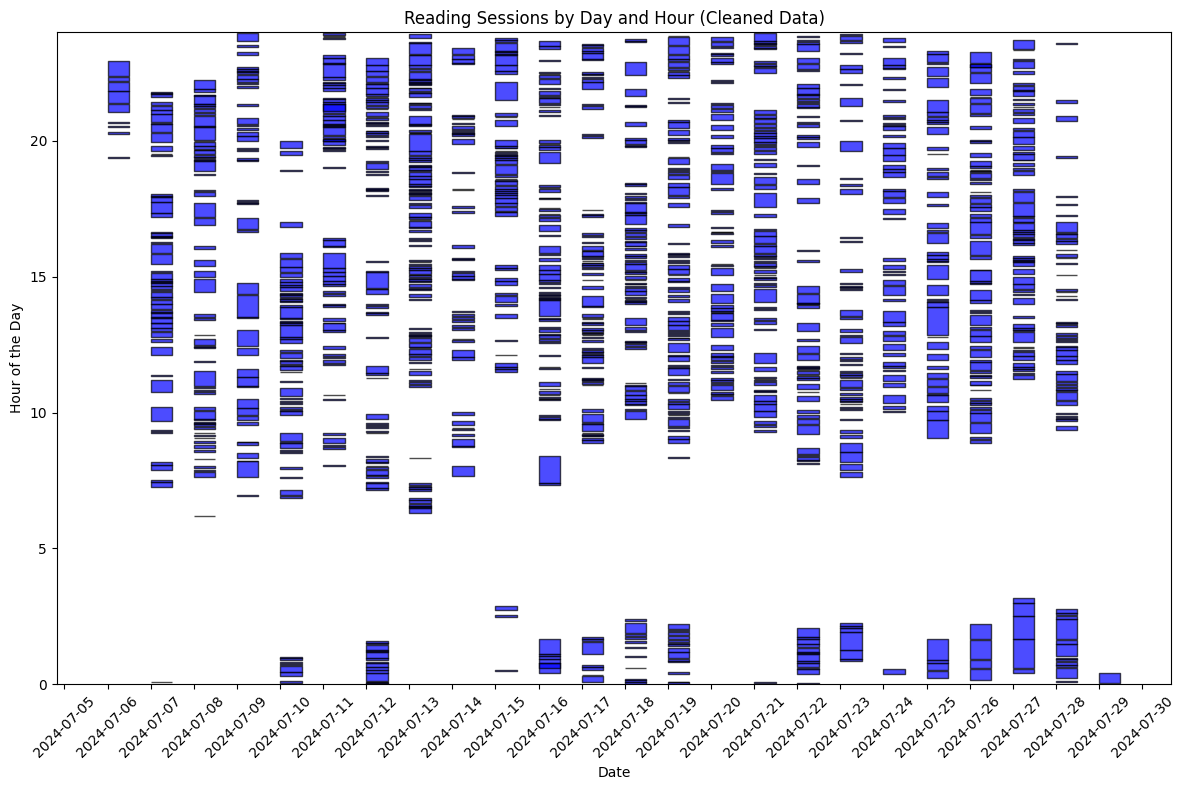

In [4]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline
# Load the dataset
file_path = 'Kindle.Devices.ReadingSession_Revised_Jupyter.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Remove rows with missing timestamps
data_cleaned = data.dropna(subset=['start_timestamp', 'end_timestamp'])

# Convert timestamps to datetime
data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')

# Remove invalid timestamps
data_cleaned = data_cleaned.dropna(subset=['start_timestamp', 'end_timestamp'])

# Add start and end hours (in decimal format)
data_cleaned['start_hour'] = data_cleaned['start_timestamp'].dt.hour + data_cleaned['start_timestamp'].dt.minute / 60
data_cleaned['end_hour'] = data_cleaned['end_timestamp'].dt.hour + data_cleaned['end_timestamp'].dt.minute / 60

# Add the date column
data_cleaned['date'] = data_cleaned['start_timestamp'].dt.date

# Calculate session durations in seconds
data_cleaned['duration'] = (data_cleaned['end_timestamp'] - data_cleaned['start_timestamp']).dt.total_seconds()

# Step 2: Filter out unrealistic and unwanted sessions
# Define thresholds
min_duration_seconds = 60  # 1 minute
max_duration_seconds = 86400  # 24 hours

# Remove sessions shorter than 1 minute and longer than 24 hours
data_filtered = data_cleaned[
    (data_cleaned['duration'] >= min_duration_seconds) & 
    (data_cleaned['duration'] <= max_duration_seconds)
]

# Remove cross-day sessions (sessions starting on one day and ending on another)
data_filtered = data_filtered[
    data_filtered['start_timestamp'].dt.date == data_filtered['end_timestamp'].dt.date
]

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each session on the graph
for row in data_filtered.itertuples():
    ax.broken_barh([(mdates.date2num(row.date), 0.5)], 
                   (row.start_hour, row.end_hour - row.start_hour), 
                   facecolors='blue', edgecolors='black', alpha=0.7)

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Set y-axis to represent hours of the day (00:00 to 24:00)
ax.set_ylim([0, 24])
ax.set_ylabel('Hour of the Day')
ax.set_xlabel('Date')
ax.set_title('Reading Sessions by Day and Hour (Cleaned Data)')

# Finalize and show the plot
plt.tight_layout()
plt.show()

C:\Users\deniz\AppData\Local\Temp\ipykernel_48856\2691233811.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
C:\Users\deniz\AppData\Local\Temp\ipykernel_48856\2691233811.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')


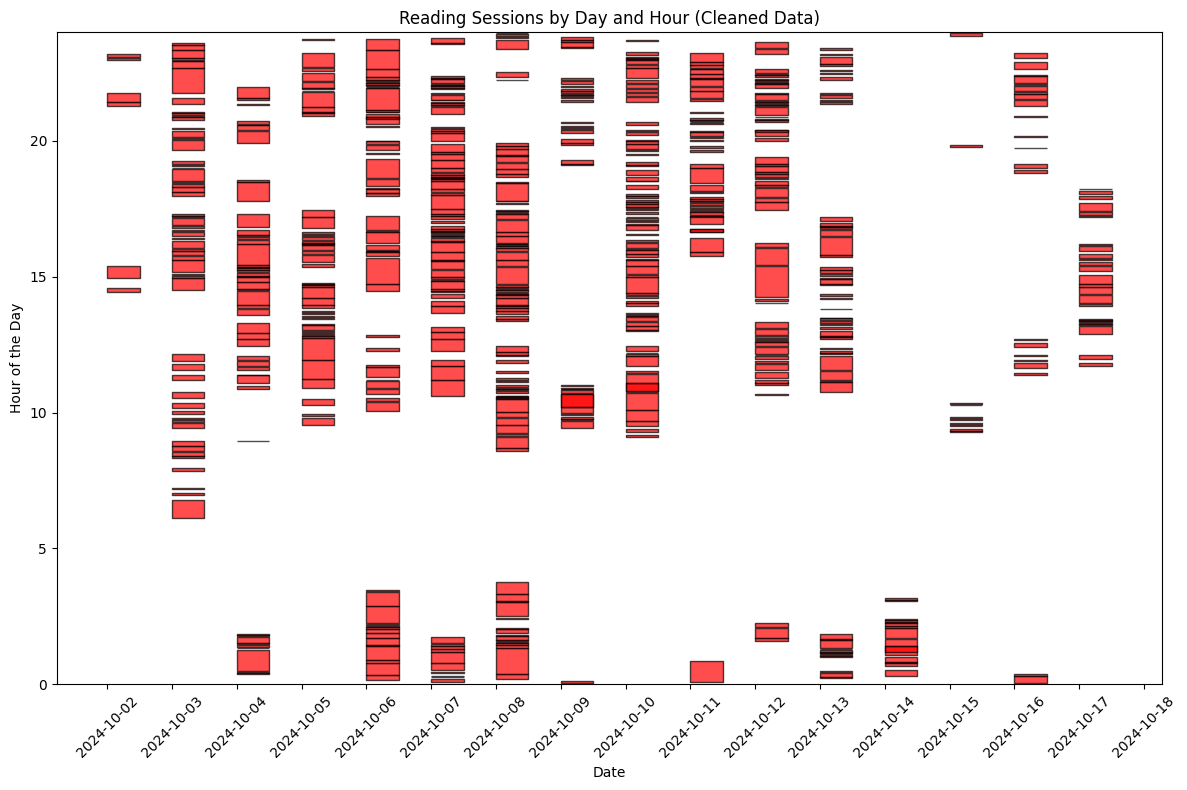

In [5]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline
# Load the dataset
file_path = 'Kindle.Devices.ReadingSession.Jupyter.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Remove rows with missing timestamps
data_cleaned = data.dropna(subset=['start_timestamp', 'end_timestamp'])

# Convert timestamps to datetime
data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')

# Remove invalid timestamps
data_cleaned = data_cleaned.dropna(subset=['start_timestamp', 'end_timestamp'])

# Add start and end hours (in decimal format)
data_cleaned['start_hour'] = data_cleaned['start_timestamp'].dt.hour + data_cleaned['start_timestamp'].dt.minute / 60
data_cleaned['end_hour'] = data_cleaned['end_timestamp'].dt.hour + data_cleaned['end_timestamp'].dt.minute / 60

# Add the date column
data_cleaned['date'] = data_cleaned['start_timestamp'].dt.date

# Calculate session durations in seconds
data_cleaned['duration'] = (data_cleaned['end_timestamp'] - data_cleaned['start_timestamp']).dt.total_seconds()

# Step 2: Filter out unrealistic and unwanted sessions
# Define thresholds
min_duration_seconds = 60  # 1 minute
max_duration_seconds = 86400  # 24 hours

# Remove sessions shorter than 1 minute and longer than 24 hours
data_filtered = data_cleaned[
    (data_cleaned['duration'] >= min_duration_seconds) & 
    (data_cleaned['duration'] <= max_duration_seconds)
]

# Remove cross-day sessions (sessions starting on one day and ending on another)
data_filtered = data_filtered[
    data_filtered['start_timestamp'].dt.date == data_filtered['end_timestamp'].dt.date
]

# Step 3: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each session on the graph
for row in data_filtered.itertuples():
    ax.broken_barh([(mdates.date2num(row.date), 0.5)], 
                   (row.start_hour, row.end_hour - row.start_hour), 
                   facecolors='red', edgecolors='black', alpha=0.7)

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Set y-axis to represent hours of the day (00:00 to 24:00)
ax.set_ylim([0, 24])
ax.set_ylabel('Hour of the Day')
ax.set_xlabel('Date')
ax.set_title('Reading Sessions by Day and Hour (Cleaned Data)')

# Finalize and show the plot
plt.tight_layout()
plt.show()

After doing an exploratory data analysis by looking the above graphs, I determined there is a gap around 06:00 for all datapoints, I presumed this is my latest time of sleep. 

To determine exactly I zoomed the graph specifically for reading sessions after midnight. 

C:\Users\deniz\AppData\Local\Temp\ipykernel_24776\2046795066.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
C:\Users\deniz\AppData\Local\Temp\ipykernel_24776\2046795066.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')


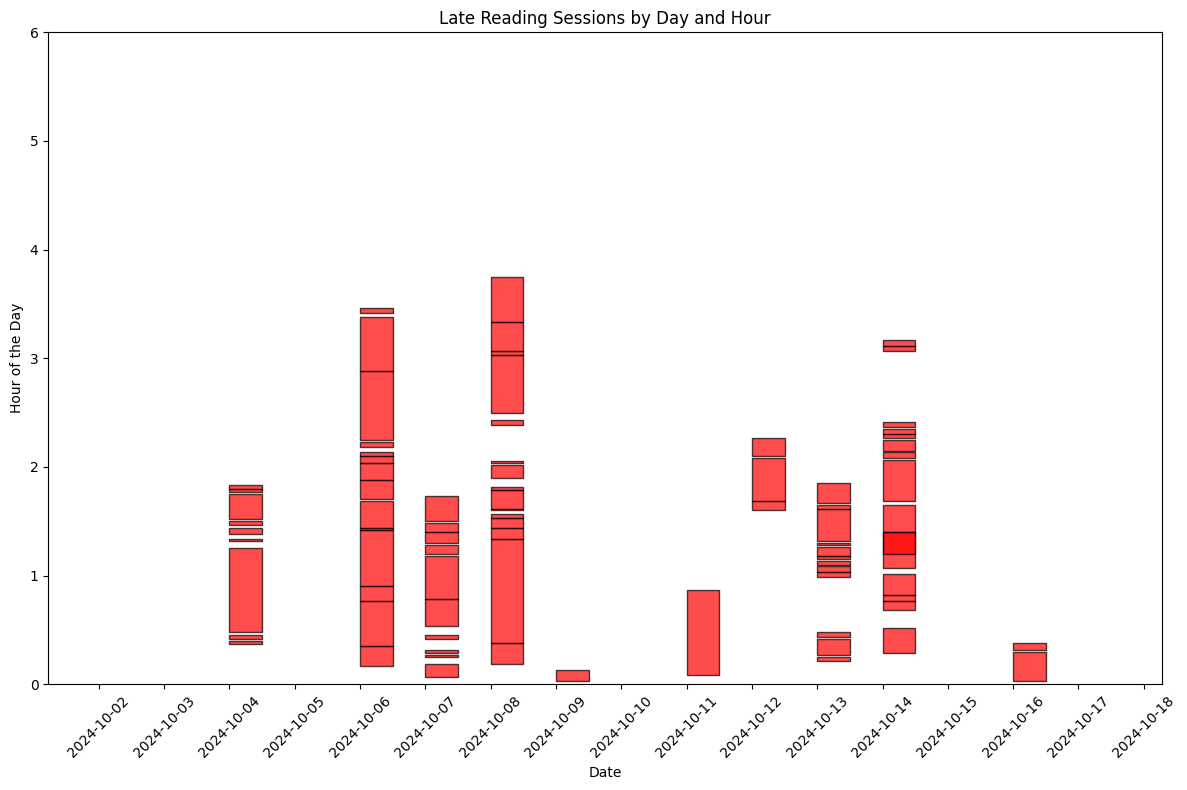

In [5]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline
# Load the dataset
file_path = 'Kindle.Devices.ReadingSession.Jupyter.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Remove rows with missing timestamps
data_cleaned = data.dropna(subset=['start_timestamp', 'end_timestamp'])

# Convert timestamps to datetime
data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')

# Remove invalid timestamps
data_cleaned = data_cleaned.dropna(subset=['start_timestamp', 'end_timestamp'])

# Add start and end hours (in decimal format)
data_cleaned['start_hour'] = data_cleaned['start_timestamp'].dt.hour + data_cleaned['start_timestamp'].dt.minute / 60
data_cleaned['end_hour'] = data_cleaned['end_timestamp'].dt.hour + data_cleaned['end_timestamp'].dt.minute / 60

# Add the date column
data_cleaned['date'] = data_cleaned['start_timestamp'].dt.date

# Calculate session durations in seconds
data_cleaned['duration'] = (data_cleaned['end_timestamp'] - data_cleaned['start_timestamp']).dt.total_seconds()

# Step 2: Filter out unrealistic and unwanted sessions
# Define thresholds
min_duration_seconds = 60  # 1 minute
max_duration_seconds = 86400  # 24 hours

# Remove sessions shorter than 1 minute and longer than 24 hours
data_filtered = data_cleaned[
    (data_cleaned['duration'] >= min_duration_seconds) & 
    (data_cleaned['duration'] <= max_duration_seconds)
]

# Remove cross-day sessions (sessions starting on one day and ending on another)
data_filtered = data_filtered[
    data_filtered['start_timestamp'].dt.date == data_filtered['end_timestamp'].dt.date
]

# Step 3: Filter sessions for late-night reading (00:00 to 08:00)
data_night_reading = data_filtered[
    (data_filtered['start_hour'] < 6) | (data_filtered['end_hour'] <= 6)
]

# Create the graph focusing on late-night reading sessions
fig, ax = plt.subplots(figsize=(12, 8))


# Plot each session on the graph
for row in data_filtered.itertuples():
    ax.broken_barh([(mdates.date2num(row.date), 0.5)], 
                   (row.start_hour, row.end_hour - row.start_hour), 
                   facecolors='red', edgecolors='black', alpha=0.7)

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Set y-axis to represent hours of the day (00:00 to 24:00)
ax.set_ylim([0, 6])
ax.set_ylabel('Hour of the Day')
ax.set_xlabel('Date')
ax.set_title('Late Reading Sessions by Day and Hour')

# Finalize and show the plot
plt.tight_layout()
plt.show()

To calculate correlation between sleeping time and reading time, I gathered my sleeping data from phone usage data and mapped it using the same code as above.

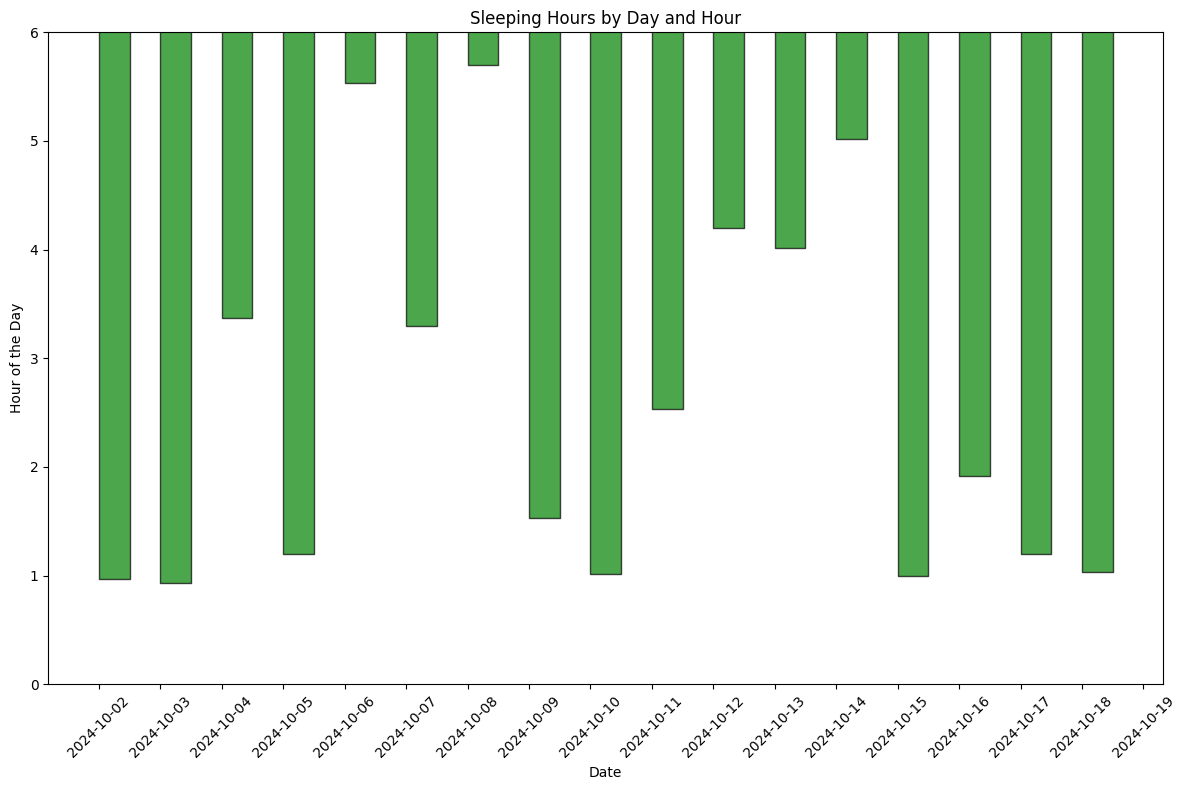

In [9]:
# Enable inline plotting for Jupyter Notebook
%matplotlib inline
# Load the dataset
file_path = 'SamsungS23_PhoneUsage_Sleep.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Remove rows with missing timestamps
data_cleaned = data.dropna(subset=['start_timestamp', 'end_timestamp'])

# Convert timestamps to datetime
data_cleaned['start_timestamp'] = pd.to_datetime(data_cleaned['start_timestamp'], errors='coerce')
data_cleaned['end_timestamp'] = pd.to_datetime(data_cleaned['end_timestamp'], errors='coerce')

# Remove invalid timestamps
data_cleaned = data_cleaned.dropna(subset=['start_timestamp', 'end_timestamp'])

# Add start and end hours (in decimal format)
data_cleaned['start_hour'] = data_cleaned['start_timestamp'].dt.hour + data_cleaned['start_timestamp'].dt.minute / 60
data_cleaned['end_hour'] = data_cleaned['end_timestamp'].dt.hour + data_cleaned['end_timestamp'].dt.minute / 60

# Add the date column
data_cleaned['date'] = data_cleaned['start_timestamp'].dt.date

# Calculate session durations in seconds
data_cleaned['duration'] = (data_cleaned['end_timestamp'] - data_cleaned['start_timestamp']).dt.total_seconds()

# Step 2: Filter out unrealistic and unwanted sessions
# Define thresholds
min_duration_seconds = 60  # 1 minute
max_duration_seconds = 86400  # 24 hours

# Remove sessions shorter than 1 minute and longer than 24 hours
data_filtered = data_cleaned[
    (data_cleaned['duration'] >= min_duration_seconds) & 
    (data_cleaned['duration'] <= max_duration_seconds)
]

# Remove cross-day sessions (sessions starting on one day and ending on another)
data_filtered = data_filtered[
    data_filtered['start_timestamp'].dt.date == data_filtered['end_timestamp'].dt.date
]

# Step 3: Filter sessions for late-night reading (00:00 to 08:00)
data_night_reading = data_filtered[
    (data_filtered['start_hour'] < 6) | (data_filtered['end_hour'] <= 6)
]

# Create the graph focusing on late-night reading sessions
fig, ax = plt.subplots(figsize=(12, 8))


# Plot each session on the graph
for row in data_filtered.itertuples():
    ax.broken_barh([(mdates.date2num(row.date), 0.5)], 
                   (row.start_hour, row.end_hour - row.start_hour), 
                   facecolors='green', edgecolors='black', alpha=0.7)

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Set y-axis to represent hours of the day (00:00 to 24:00)
ax.set_ylim([0, 6])
ax.set_ylabel('Hour of the Day')
ax.set_xlabel('Date')
ax.set_title('Sleeping Hours by Day and Hour')

# Finalize and show the plot
plt.tight_layout()
plt.show()

Ending time of the days latest reading session is compared with starting time of sleep for each day.

Result shows correlation value of nearly +1, but this result may occur because of an overlap between amazons kindle data and phone usage data app.

Still there is high probability that reading at late and sleeping are correlated even with the data overlap.

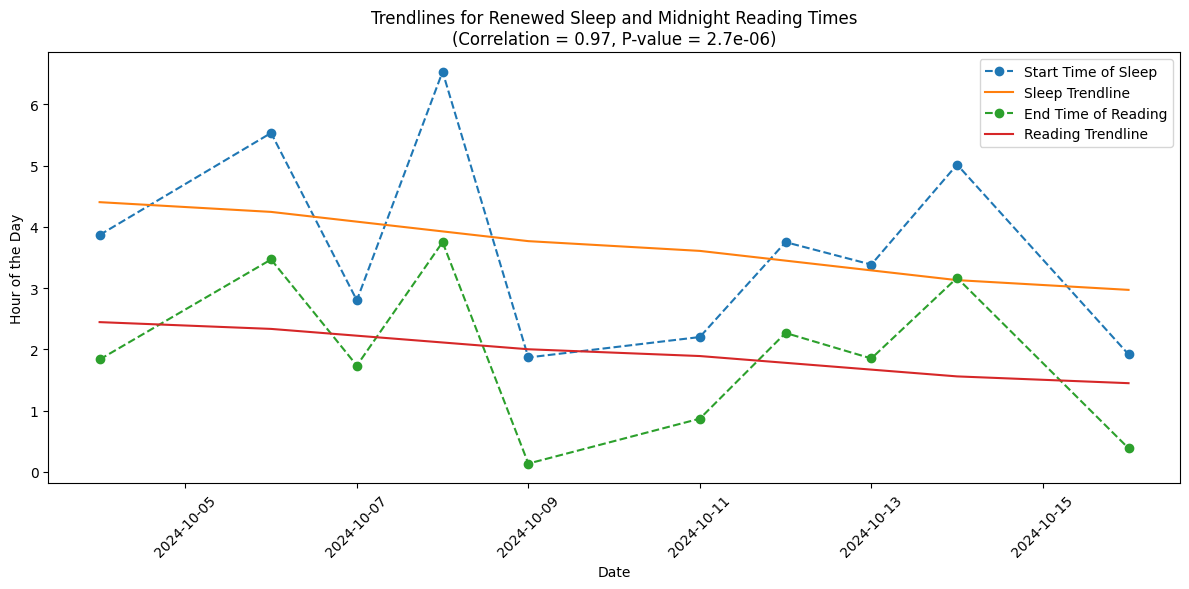

In [15]:
renewed_sleep_data = pd.read_csv('SamsungS23_PhoneUsage_Sleep.csv')
reading_data = pd.read_csv('Kindle.Devices.ReadingSession.Jupyter.csv')

# Preprocess the renewed sleep data
renewed_sleep_data['start_timestamp'] = pd.to_datetime(renewed_sleep_data['start_timestamp'])
renewed_sleep_data['start_hour'] = renewed_sleep_data['start_timestamp'].dt.hour + renewed_sleep_data['start_timestamp'].dt.minute / 60
renewed_sleep_data['date'] = renewed_sleep_data['start_timestamp'].dt.date

# Filter reading data for midnight (00:00 to 06:00)
reading_data['end_timestamp'] = pd.to_datetime(reading_data['end_timestamp'])
reading_data['end_hour'] = reading_data['end_timestamp'].dt.hour + reading_data['end_timestamp'].dt.minute / 60
reading_data['date'] = reading_data['end_timestamp'].dt.date
midnight_reading_data = reading_data[(reading_data['end_hour'] >= 0) & (reading_data['end_hour'] <= 6)]
latest_midnight_reading = midnight_reading_data.groupby('date')['end_hour'].last().reset_index()

# Merge the midnight reading data with the renewed sleep data
aligned_new_sleep_data = pd.merge(
    renewed_sleep_data[['date', 'start_hour']],
    latest_midnight_reading,
    on='date',
    how='inner'
)

# Calculate time difference
aligned_new_sleep_data['time_difference'] = aligned_new_sleep_data['start_hour'] - aligned_new_sleep_data['end_hour']

# Recalculate correlation

new_correlation, new_p_value = pearsonr(
    aligned_new_sleep_data['start_hour'], aligned_new_sleep_data['end_hour']
)

# Plot the trendlines
plt.figure(figsize=(12, 6))

# Sleep start time trendline
plt.plot(
    aligned_new_sleep_data['date'],
    aligned_new_sleep_data['start_hour'],
    label='Start Time of Sleep',
    marker='o',
    linestyle='--',
)
z_new_sleep = np.polyfit(range(len(aligned_new_sleep_data)), aligned_new_sleep_data['start_hour'], 1)
p_new_sleep = np.poly1d(z_new_sleep)
plt.plot(
    aligned_new_sleep_data['date'],
    p_new_sleep(range(len(aligned_new_sleep_data))),
    label='Sleep Trendline',
)

# Reading end time trendline
plt.plot(
    aligned_new_sleep_data['date'],
    aligned_new_sleep_data['end_hour'],
    label='End Time of Reading',
    marker='o',
    linestyle='--',
)
z_new_reading = np.polyfit(range(len(aligned_new_sleep_data)), aligned_new_sleep_data['end_hour'], 1)
p_new_reading = np.poly1d(z_new_reading)
plt.plot(
    aligned_new_sleep_data['date'],
    p_new_reading(range(len(aligned_new_sleep_data))),
    label='Reading Trendline',
)

# Formatting plot
plt.xticks(rotation=45)
plt.ylabel('Hour of the Day')
plt.xlabel('Date')
plt.title(
    f'Trendlines for Renewed Sleep and Midnight Reading Times\n(Correlation = {new_correlation:.2f}, P-value = {new_p_value:.2g})'
)
plt.legend()
plt.tight_layout()
plt.show()

One other point I wanted to obeserve was the correlation between total reading hour and sleeping duration of the same day.

Result showed that the data is not significant enough and correlation does not signify anything either.

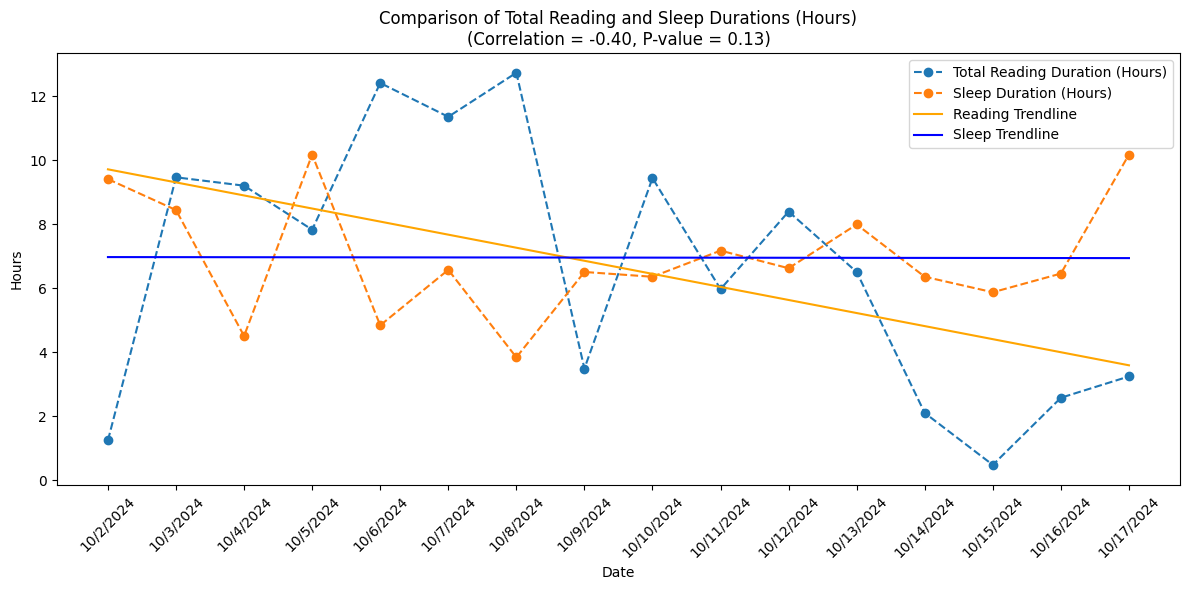

In [16]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Load the preprocessed dataset
data_path = "Reading_Sleep_Duration_Hours.csv"  # Replace with your actual file path
data = pd.read_csv(data_path)

# Calculate correlation
correlation, p_value = pearsonr(data['reading_duration_hours'], data['sleep_duration_hours'])

# Plot the graph with trendlines
plt.figure(figsize=(12, 6))

# Plot total reading duration in hours
plt.plot(
    data['date'],
    data['reading_duration_hours'],
    label='Total Reading Duration (Hours)',
    marker='o',
    linestyle='--',
)

# Plot sleep duration in hours
plt.plot(
    data['date'],
    data['sleep_duration_hours'],
    label='Sleep Duration (Hours)',
    marker='o',
    linestyle='--',
)

# Add trendlines
z_reading = np.polyfit(range(len(data)), data['reading_duration_hours'], 1)
p_reading = np.poly1d(z_reading)
plt.plot(data['date'], p_reading(range(len(data))), label='Reading Trendline', color="orange")
z_sleep = np.polyfit(range(len(data)), data['sleep_duration_hours'], 1)
p_sleep = np.poly1d(z_sleep)
plt.plot(data['date'], p_sleep(range(len(data))), label='Sleep Trendline', color="blue")

# Formatting plot
plt.xticks(rotation=45)
plt.ylabel('Hours')
plt.xlabel('Date')
plt.title(
    f'Comparison of Total Reading and Sleep Durations (Hours)\n(Correlation = {correlation:.2f}, P-value = {p_value:.2g})'
)
plt.legend()
plt.tight_layout()
plt.show()

## Hypothesis Testing using T-Test
After gathering all the correlations and observations about my datasets I concluded that there may be connection between after midnight reading duration and sleep duration.  

Null Hypothesis: There is no significant relationship between the total duration of reading after midnight and the total duration of sleep on the same day.

Alternative Hypothesis: There is a significant relationship between the total duration of reading after 00:00 (midnight) and the total duration of sleep on the same day.

Total number of days are less than 30 (n<30) so t-test is used.

Standart significence level (α = 0.05) is used.


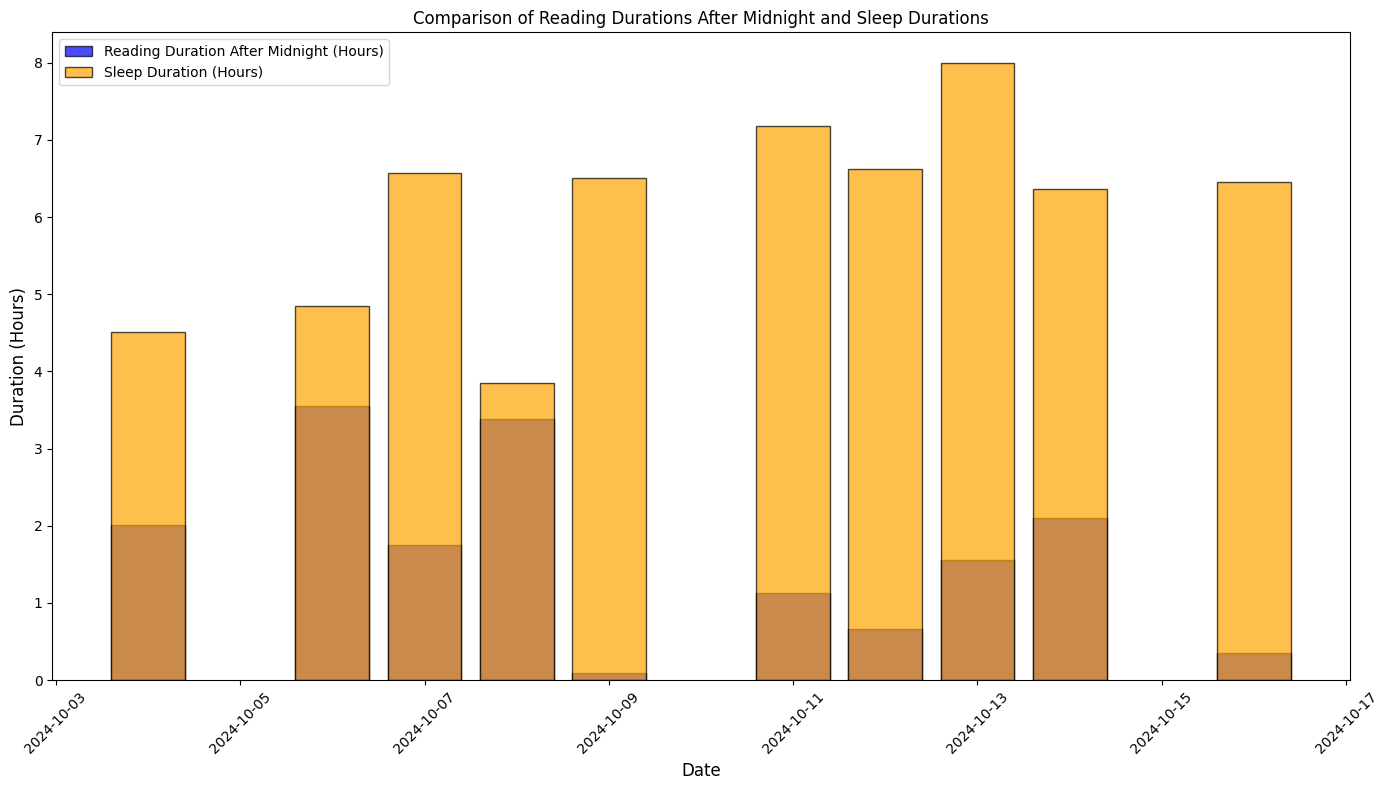

T-Test Results:
Reading Duration (Mean ± SD): 1.66 ± 1.17 hours
Sleep Duration (Mean ± SD): 6.09 ± 1.28 hours
T-Statistic: -8.07
P-Value: 2.3e-07
Significance Level: α = 0.05
Conclusion: Reject the null hypothesis.


In [31]:
# File paths for the datasets
sleep_data_path = "SamsungS23_PhoneUsage_Sleep.csv"  # Replace with your actual file path
reading_data_path = 'Kindle.Devices.ReadingSession.Jupyter.csv'  # Replace with your actual file path


# Load the datasets
reading_data = pd.read_csv(reading_data_path)
sleep_data = pd.read_csv(sleep_data_path)

# Preprocess reading data to calculate reading duration after midnight (in hours)
reading_data['end_timestamp'] = pd.to_datetime(reading_data['end_timestamp'])
reading_data['end_hour'] = reading_data['end_timestamp'].dt.hour + reading_data['end_timestamp'].dt.minute / 60
reading_data['reading_duration_hours'] = reading_data['total_reading_millis'] / (1000 * 60 * 60)  # Convert millis to hours

# Filter for reading sessions after midnight (00:00 to 06:00)
reading_after_midnight = reading_data[(reading_data['end_hour'] >= 0) & (reading_data['end_hour'] <= 6)]

# Sum reading durations after midnight per day
reading_duration_per_day = reading_after_midnight.groupby(reading_after_midnight['end_timestamp'].dt.date)['reading_duration_hours'].sum().reset_index()
reading_duration_per_day.columns = ['date', 'reading_duration_after_midnight']

# Preprocess sleep data to calculate total sleep duration (in hours)
sleep_data['start_timestamp'] = pd.to_datetime(sleep_data['start_timestamp'])
sleep_data['end_timestamp'] = pd.to_datetime(sleep_data['end_timestamp'])
sleep_data['sleep_duration_hours'] = (sleep_data['end_timestamp'] - sleep_data['start_timestamp']).dt.total_seconds() / (60 * 60)  # Convert seconds to hours

# Sum sleep durations per day
sleep_duration_per_day = sleep_data.groupby(sleep_data['start_timestamp'].dt.date)['sleep_duration_hours'].sum().reset_index()
sleep_duration_per_day.columns = ['date', 'sleep_duration']

# Merge reading and sleep data
merged_data = pd.merge(reading_duration_per_day, sleep_duration_per_day, on='date', how='inner')

# Plot the comparison of reading durations after midnight and sleep durations
plt.figure(figsize=(14, 8))

# Reading durations after midnight
plt.bar(
    merged_data['date'],
    merged_data['reading_duration_after_midnight'],
    label='Reading Duration After Midnight (Hours)',
    alpha=0.7,
    color='blue'
)

# Sleep durations
plt.bar(
    merged_data['date'],
    merged_data['sleep_duration'],
    label='Sleep Duration (Hours)',
    alpha=0.7,
    color='orange'
)

# Formatting the plot
plt.xticks(rotation=45, fontsize=10)
plt.ylabel('Duration (Hours)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Comparison of Reading Durations After Midnight and Sleep Durations')
plt.legend()
plt.tight_layout()
plt.show()

# Extract the necessary data for the t-test
reading_hours = merged_data['reading_duration_after_midnight']
sleep_hours = merged_data['sleep_duration']
t_stat, p_value = ttest_ind(reading_hours, sleep_hours, equal_var=False)

# Calculate descriptive statistics for transparency
reading_mean = reading_hours.mean()
reading_std = reading_hours.std()
sleep_mean = sleep_hours.mean()
sleep_std = sleep_hours.std()

# Add t-test results to the graph
plt.figure(figsize=(12, 6))

# Reading durations after midnight
plt.bar(
    merged_data['date'],
    merged_data['reading_duration_after_midnight'],
    label='Reading Duration After Midnight (Hours)',
    alpha=0.7,
    color='blue'
)

# Sleep durations
plt.bar(
    merged_data['date'],
    merged_data['sleep_duration'],
    label='Sleep Duration (Hours)',
    alpha=0.7,
    color='orange'
)

# Formatting the plot
plt.xticks(rotation=45)
plt.ylabel('Duration (Hours)')
plt.xlabel('Date')
plt.title('Comparison of Reading Durations After Midnight and Sleep Durations')

# Annotate with t-test results
plt.text(
    0.5, max(max(merged_data['reading_duration_after_midnight']), max(merged_data['sleep_duration'])) - 1,
    f"T-Statistic: {t_stat:.2f}\nP-Value: {p_value:.2g}\n"
    f"Reading Mean: {reading_mean:.2f} hrs\nSleep Mean: {sleep_mean:.2f} hrs",
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.legend(fontsize=10)

plt.subplots_adjust(bottom=0.3)
plt.show()

# Print summary table
print("T-Test Results:")
print(f"Reading Duration (Mean ± SD): {reading_mean:.2f} ± {reading_std:.2f} hours")
print(f"Sleep Duration (Mean ± SD): {sleep_mean:.2f} ± {sleep_std:.2f} hours")
print(f"T-Statistic: {t_stat:.2f}")
print(f"P-Value: {p_value:.2g}")
print(f"Significance Level: α = 0.05")
if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis.")
else:
    print("Conclusion: Fail to reject the null hypothesis.")

##  Machine Learning Model
Training and Testing data is split to 80/20.

Model estimates sleep duration according to Reading duration after midnight using Linear Regression.

Too few sample for the training hurts the overall accuracy of the model, but the results are not overfitted and meaningfull data can be earned from the model.


Mean Squared Error: 0.39
R-Squared: 0.32


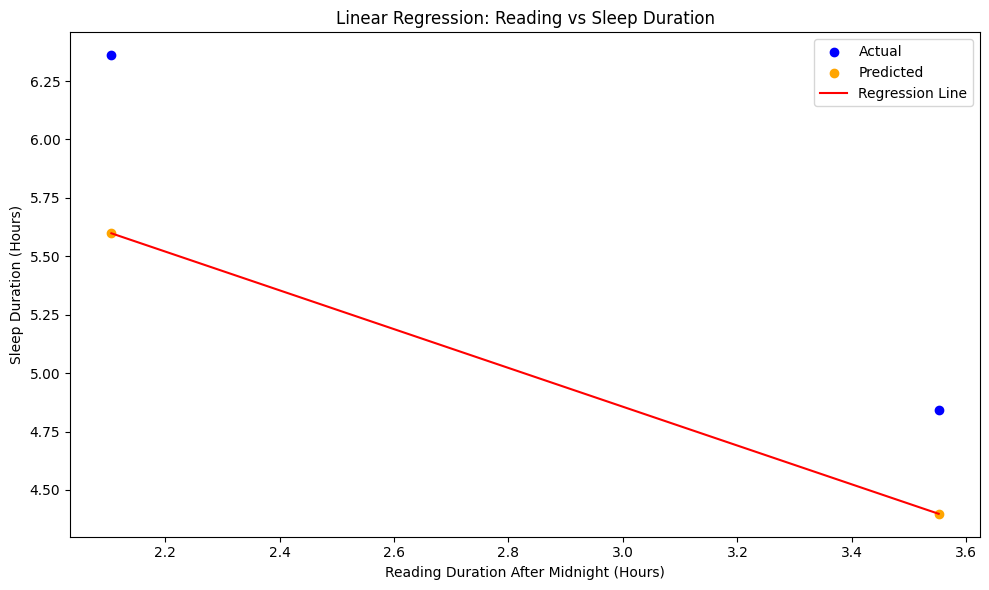

In [35]:

# Prepare features and target
X = merged_data[['reading_duration_after_midnight']]  # Feature
y = merged_data['sleep_duration']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-Squared: {r2:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label='Actual', color='blue')
plt.scatter(X_test, y_pred, label='Predicted', color='orange')
plt.plot(X_test, y_pred, color='red', label='Regression Line')
plt.xlabel('Reading Duration After Midnight (Hours)')
plt.ylabel('Sleep Duration (Hours)')
plt.title('Linear Regression: Reading vs Sleep Duration')
plt.legend()
plt.tight_layout()
plt.show()
